In [712]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [713]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans

In [714]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
#from config import *

In [715]:
%matplotlib inline

In [716]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [717]:
# make sure that matplotib and seaborn can show Chinese
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

In [718]:
# Files to use 
filenamePrice = 'Own_Factor_AdjustedPriceForward-1d.csv'
filenameST = 'LZ_GPA_SLCIND_ST_FLAG.csv'
filenameTradeday = 'LZ_GPA_SLCIND_TRADEDAYCOUNT.csv'
filenameStopFlag = 'LZ_GPA_SLCIND_STOP_FLAG.csv'
filenameIndu = 'LZ_GPA_INDU_ZX.csv'
filenameFCAP = 'LZ_GPA_VAL_A_FCAP.csv'
filenameAdjustFactor = 'LZ_GPA_CMFTR_CUM_FACTOR.csv'
filenameHS300 = 'LZ_GPA_INDXQUOTE_CLOSE.csv'
filenameZXIndustry = 'LZ_GPA_INDU_ZX.csv'
filenameZXExplanation = 'LZ_GPA_TMP_INDU_ZX.csv'

In [719]:
# Constants
startTime =  datetime.strptime('20161201', '%Y%m%d')
endTime = datetime.strptime('20170429', '%Y%m%d')

path = ff.data_path
timeStampNum = 2500
thresholdNum = 0.2
HS300Index ='000300.SH' # HS300 index code
ZZ500Index = '000905.SH' #   ZZ500 index code

In [720]:
stDF = pd.read_csv(path+filenameST,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
tradeDayDF = pd.read_csv(path+filenameTradeday,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
stopFlagDF = pd.read_csv(path+filenameStopFlag,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
indusDF = pd.read_csv(path+filenameZXIndustry,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
induExplanation = pd.read_csv(path+filenameZXExplanation,infer_datetime_format=True,parse_dates=[0],encoding='gb2312')

In [721]:
# Uqer factor
filenameUQAD20 = 'Uqer_factor_AD20.csv'    # group9最好，有2%左右的超额收益，其他组都没有超额收益，多空效果很好，有较好的单调性（但是单调性反转，长期是group0最小）（证明类动量/价因子还是效果比较好的）
filenameUQADTM = 'Uqer_factor_ADTM.csv'    # 因子失效中（没有超额收益），失去单调性
filenameUQATR6 = 'Uqer_factor_ATR6.csv'    # group1最好，有0.2%左右的超额收益，其他组都没有超额收益，多空效果很好，有较好的单调性
filenameUQAroon = 'Uqer_factor_Aroon.csv'   # 因子失效中（几乎没有超额收益），失去单调性 
filenameUQBias10 = 'Uqer_factor_BIAS10.csv' # 因子失效中（几乎没有超额收益），失去单调性 

In [722]:
# Own factor
filenameOWNILLIQ ='Own_Factor_ILLQ-1d.csv'
filenameSharpe = 'Own_Factor_sharpe_ratio_20D.csv'

filenameTOV20 = 'Own_Factor_Turnover_Volatility_20D.csv' # group0 最好，有年化 10%的收益率，单调性很好，多空效果也很好，
 #但是市值单调递减，group0市值最大，可能选到了上证50（大市值股票交易比较稳定，因此换手率波动较小）
filenameADJTOV20 = 'Own_Factor_ADJ_Turnover_Volatility_20D.csv' # 单调性较好，但是没有超额收益 
filenameTOVD20 = 'Own_Factor_Turnover_Volatility_deviation_20D.csv' # 无单调性，无超额收益
filenameADJTOVD20 = 'Own_Factor_ADJ_Turnover_Volatility_Deviation_20D.csv' # 无单调性，无超额收益

In [966]:
sololist = [filenameADJTOVD20]

In [967]:
sparedata = pd.read_csv(path+sololist[0],infer_datetime_format=True,parse_dates=[0],index_col=0)

In [968]:
# adjust the columns name of the Uqer data same as the own factor
if 'Uqer' in sololist[0]: 
    uqercolumnList = sparedata.columns.tolist()
    uqercolumnName = [x.split('.')[0] for x in uqercolumnList]
    newcolumnList = stDF.columns.tolist()
    newcolumnName = [x.split('.')[0] for x in newcolumnList]
    columndict = dict(zip(newcolumnName,newcolumnList))
    finalcolumns = []
    for stk in uqercolumnName:
        if stk in newcolumnName:
            stk = columndict[stk]
        else:
            pass
        finalcolumns.append(stk)
    sparedata.columns = finalcolumns
    addNanColumns = list(set(newcolumnList) - set(sparedata.columns))
    addData = pd.DataFrame(index = sparedata.index,columns = addNanColumns,dtype =float)
    sparedata = pd.concat([sparedata,addData],axis=1)
    sparedata = sparedata[newcolumnList]

In [969]:
priceData =  pd.read_csv(path+ filenamePrice ,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
benchMarkData = pd.read_csv(path+filenameHS300,infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime][ZZ500Index]

In [970]:
LFCAPDF = np.log10(ff.getData(thresholdNum, startTime, endTime,filename = filenameFCAP))

In [971]:
LFCAPDF

,000005.SZ,600601.SH,600602.SH,600651.SH,600652.SH,600653.SH,600654.SH,000004.SZ,000002.SZ,000001.SZ,...,603577.SH,002832.SZ,300579.SZ,603058.SH,600996.SH,603298.SH,002833.SZ,002835.SZ,300582.SZ,603218.SH
LZ_GPA_VAL_A_FCAP-d,,,,,,,,,,,,,,,,,,,,,
2016-12-01,5.832980,6.042117,5.962139,5.956489,5.961952,5.888543,6.168674,5.540260,7.418016,7.147551,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-02,5.820563,6.033378,5.949452,5.944518,5.947681,5.880628,6.157182,5.535352,7.409560,7.145283,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-05,5.818157,6.028049,5.947732,5.946033,5.944833,5.872567,6.151205,5.539116,7.393675,7.141171,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-06,5.817553,6.028942,5.949023,5.944518,5.946733,5.867451,6.154663,5.545422,7.391626,7.142546,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-07,5.821761,6.031609,5.952872,5.946788,5.950196,5.874596,6.167115,5.557964,7.387500,7.142088,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-08,5.816343,6.025360,5.948163,5.939559,5.944197,5.869505,6.161951,5.552142,7.380534,7.143916,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-09,5.817553,6.024460,5.946438,5.938022,5.937792,5.867451,6.161499,5.552142,7.381761,7.149807,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-12,5.795245,5.998469,5.927898,5.907729,5.917312,5.843112,6.120265,5.518759,7.353744,7.143003,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595
2016-12-13,5.796515,5.996551,5.921080,5.913877,5.917650,5.842022,6.119269,5.526116,7.349994,7.139330,...,4.668662,5.002134,4.583879,4.460591,5.430784,5.198844,4.686387,4.681051,4.848522,5.149595


In [972]:
endOfWeekList = sorted(list(set(LFCAPDF.iloc[LFCAPDF.resample('W').size().cumsum().sub(1)].index)))

In [973]:
endOfWeekList 

[Timestamp('2016-12-02 00:00:00'),
 Timestamp('2016-12-09 00:00:00'),
 Timestamp('2016-12-16 00:00:00'),
 Timestamp('2016-12-23 00:00:00'),
 Timestamp('2016-12-30 00:00:00'),
 Timestamp('2017-01-06 00:00:00'),
 Timestamp('2017-01-13 00:00:00'),
 Timestamp('2017-01-20 00:00:00'),
 Timestamp('2017-01-26 00:00:00'),
 Timestamp('2017-02-03 00:00:00'),
 Timestamp('2017-02-10 00:00:00'),
 Timestamp('2017-02-17 00:00:00'),
 Timestamp('2017-02-24 00:00:00'),
 Timestamp('2017-03-03 00:00:00'),
 Timestamp('2017-03-10 00:00:00'),
 Timestamp('2017-03-17 00:00:00'),
 Timestamp('2017-03-24 00:00:00'),
 Timestamp('2017-03-31 00:00:00'),
 Timestamp('2017-04-07 00:00:00'),
 Timestamp('2017-04-14 00:00:00'),
 Timestamp('2017-04-21 00:00:00'),
 Timestamp('2017-04-28 00:00:00')]

In [974]:
# calculate correlation between two factors
if  'Uqer' in sololist[0]:
    factor1 = sparedata.loc[startTime:endTime]
else:
    factor1 = pd.read_csv(path+sololist[0],infer_datetime_format=True,parse_dates=[0],index_col=0).loc[startTime:endTime]
#correlationDF = ff.showCorrelation(factor1,LFCAPDF, endOfWeekList, filterdic = None).astype(float)
#correlationDF.describe()

In [975]:
activeReturnData = ff.calcReturn(priceData, endOfWeekList, benchmark = benchMarkData,activeReturn = True,logReturn = False)

In [976]:
# Generate the useles stock list
filterdict={}
for i in endOfWeekList:
    suspendList = ff.GetSTNewSuspend(i,stDF,tradeDayDF,stopFlagDF)
    filterdict[i] = suspendList
    print i, len(filterdict[i])

2016-12-02 00:00:00 391
2016-12-09 00:00:00 392
2016-12-16 00:00:00 404
2016-12-23 00:00:00 413
2016-12-30 00:00:00 404
2017-01-06 00:00:00 408
2017-01-13 00:00:00 416
2017-01-20 00:00:00 422
2017-01-26 00:00:00 428
2017-02-03 00:00:00 432
2017-02-10 00:00:00 445
2017-02-17 00:00:00 448
2017-02-24 00:00:00 457
2017-03-03 00:00:00 449
2017-03-10 00:00:00 446
2017-03-17 00:00:00 448
2017-03-24 00:00:00 451
2017-03-31 00:00:00 444
2017-04-07 00:00:00 448
2017-04-14 00:00:00 456
2017-04-21 00:00:00 451
2017-04-28 00:00:00 453


In [977]:
### Calculate the return of each group of given factor(solo factor)
totalGroupDict ={}
factorData = ff.getData(thresholdNum, startTime, endTime,availableData = factor1)

for date in endOfWeekList:
    factorDataTemp = factorData.loc[:date].tail()
    factorDataTemp = factorDataTemp[list(set(factorDataTemp.columns.tolist())- set(filterdict[date]))]
    #print factorDataTemp
    totalGroupDict[date] = ff.getStockGroup(factorDataTemp,groupNum=10,Mean_Num=1)

In [978]:
factorData

,000005.SZ,600601.SH,600602.SH,600651.SH,600652.SH,600653.SH,600654.SH,000004.SZ,000002.SZ,000001.SZ,...,002735.SZ,300407.SZ,300408.SZ,300409.SZ,603518.SH,603368.SH,002732.SZ,603998.SH,601969.SH,601226.SH
Own_Factor_ADJ_Turnover_Volatility_Deviation_20D,,,,,,,,,,,,,,,,,,,,,
2016-12-01,-0.337171,-0.587174,-0.428266,0.054828,-0.469002,-0.611453,0.947917,0.309915,0.466463,0.158174,...,4.374915,-0.484573,-0.780723,-0.464869,-1.305737,0.842278,1.401179,0.067761,-0.912702,-0.584864
2016-12-02,-0.316283,-0.620450,-0.425720,0.066478,-0.489582,-0.615835,0.942637,0.163000,0.439528,0.158998,...,4.374915,-0.484573,-0.780723,-0.464869,-1.305737,0.842278,1.401179,0.067761,-0.912702,-0.584864
2016-12-05,-0.354616,-0.632563,-0.436589,0.082495,-0.499880,-0.613196,0.894368,0.077537,0.417052,0.146823,...,4.374915,-0.484573,-0.780723,-0.464869,-1.305737,0.842278,1.401179,0.067761,-0.912702,-0.584864
2016-12-06,-0.371004,-0.656266,-0.443308,-0.017737,-0.498743,-0.616573,0.872965,0.003404,0.396104,0.113326,...,4.374915,-0.484573,-0.780723,-0.464869,-1.305737,0.842278,1.401179,0.067761,-0.912702,-0.584864
2016-12-07,-0.370378,-0.663312,-0.469865,-0.044033,-0.516396,-0.607889,0.790886,-0.032591,0.163162,0.082179,...,4.374915,-0.484573,-0.780723,-0.464869,-1.305737,0.842278,1.401179,0.067761,-0.912702,-0.584864
2016-12-08,-0.400633,-0.659102,-0.470379,-0.075393,-0.504207,-0.617497,0.777566,-0.067315,0.018819,0.074346,...,4.374915,-0.484573,-0.780723,-0.464869,-1.305737,0.842278,1.401179,0.067761,-0.912702,-0.584864
2016-12-09,-0.405806,-0.655476,-0.460898,-0.075326,-0.480769,-0.617552,0.773336,-0.082135,-0.011699,0.126719,...,4.374915,-0.484573,-0.780723,-0.464869,-1.305737,0.842278,1.401179,0.067761,-0.912702,-0.584864
2016-12-12,-0.395313,-0.659577,-0.431131,-0.051986,-0.472062,-0.573631,0.820925,-0.078010,-0.007492,0.161896,...,4.374915,-0.484573,-0.780723,-0.464869,-1.305737,0.842278,1.401179,0.067761,-0.912702,-0.584864
2016-12-13,-0.407191,-0.662461,-0.472072,-0.119385,-0.523905,-0.530825,0.635005,-0.097591,-0.087809,0.159227,...,4.374915,-0.484573,-0.780723,-0.464869,-1.305737,0.842278,1.401179,0.067761,-0.912702,-0.584864


In [979]:
ReturnDF = pd.DataFrame(index=endOfWeekList[:-1],columns=totalGroupDict.values()[0].keys(),data=None, dtype =float)
sizeDistribution = pd.DataFrame(index=endOfWeekList[:-1],columns=totalGroupDict.values()[0].keys(),data=None, dtype =float)
for group in ReturnDF.columns.tolist():
    for time in ReturnDF.index:
        ReturnDF.loc[time][group] = activeReturnData.loc[time][totalGroupDict[time][group]].mean()
        sizeDistribution.loc[time][group] = LFCAPDF.loc[time][totalGroupDict[time][group]].quantile()
ReturnDF.sort_index(axis=1,inplace=True)
sizeDistribution.sort_index(axis=1,inplace=True)

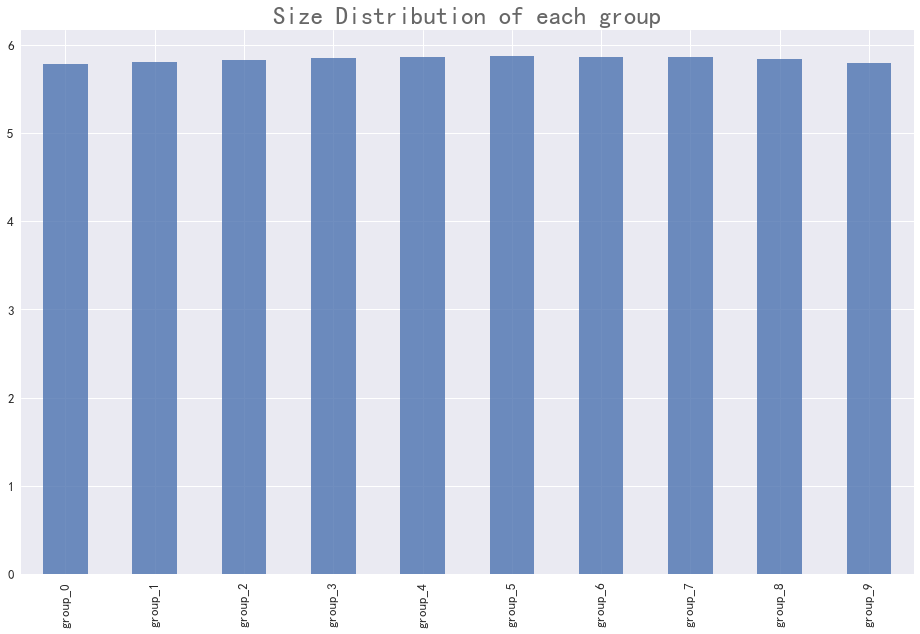

In [980]:
# show size distribution(quantile plot)
fig = plt.figure(figsize=(16,10))
# Add a subplot
ax = fig.add_subplot(111)
sizeDistribution.median().plot(kind='bar',ax = ax, fontsize =13,title ='Size Distribution of each group',alpha =0.8)
ax.set_title(ax.get_title(),alpha=0.7, fontsize=25)

In [981]:
# Calc spearman correlation to investigate monotonicity
referSeries = pd.Series(index = ReturnDF.columns, data=range(len(ReturnDF.columns)))
monoDF = pd.DataFrame(index = ReturnDF.index, columns=['Spearman_Cor'], dtype = float)
for date in ReturnDF.index:
    monoDF.loc[date] = ReturnDF.loc[date].corr(referSeries,method='spearman')   

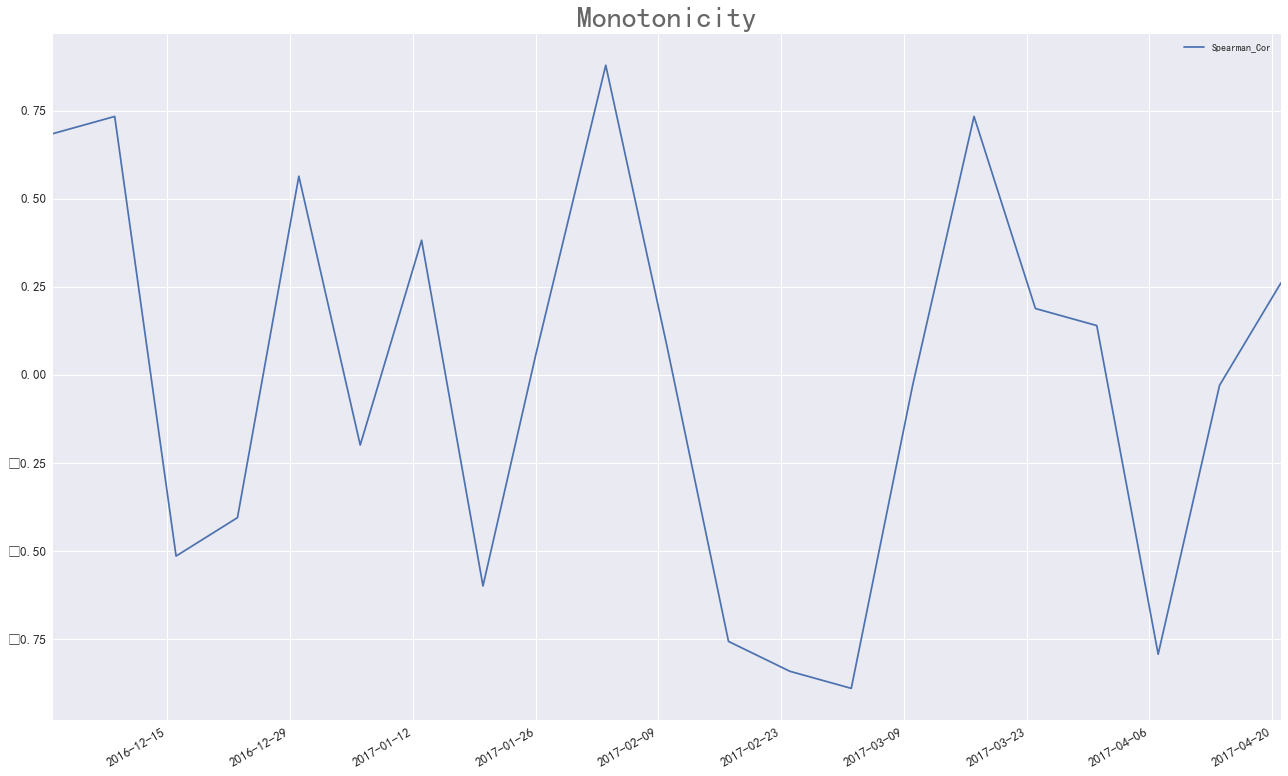

In [982]:
# Plot
fig = plt.figure(figsize=(18,14))
# Add a subplot
ax = fig.add_subplot(111)
monoDF.plot(figsize=(22,14),ax=ax,fontsize =13,title ='Monotonicity')
ax.set_title(ax.get_title(),alpha=0.7, fontsize=30)

In [983]:
# long top group short bot group 
sortGroups = ReturnDF[['group_0','group_9']].cumsum().iloc[-1].sort_values(ascending = False).index
top, bot = sortGroups[0], sortGroups[-1]

# Add another column
ReturnDF['top_bot_comb'] = ReturnDF[top] - ReturnDF[bot]

In [984]:
ReturnDF

,group_0,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,top_bot_comb
2016-12-02,-0.001072,0.001127,-0.001078,0.003358,-0.000824,0.001908,0.001356,0.000150,0.004122,0.011229,-0.012301
2016-12-09,-0.004891,-0.006703,-0.010704,-0.008284,0.000455,-0.004200,-0.000965,-0.000132,-0.002940,0.012475,-0.017367
2016-12-16,0.003078,0.007521,0.003387,0.004601,0.000417,0.003659,-0.000201,0.003726,0.000924,-0.014977,0.018055
2016-12-23,0.005273,0.005541,0.008239,0.007011,0.005323,0.008195,0.009810,0.000481,0.000147,0.002431,0.002842
2016-12-30,-0.000032,0.001805,-0.000382,-0.000735,0.001209,0.000123,0.000908,0.008142,0.003823,0.001491,-0.001523
2017-01-06,-0.007942,-0.002907,-0.005009,0.000373,-0.002862,-0.004067,-0.002453,-0.004032,-0.005882,-0.026676,0.018735
2017-01-13,-0.016395,-0.014348,-0.006549,-0.007232,-0.005696,-0.005415,0.000112,-0.003890,-0.007334,-0.011964,-0.004431
2017-01-20,0.005983,0.001626,-0.000938,0.001689,0.000953,-0.000668,0.002142,-0.001873,-0.000293,-0.011409,0.017392
2017-01-26,-0.000268,-0.001401,-0.001849,-0.001488,-0.001278,-0.000673,-0.001718,-0.000421,-0.002305,0.004779,-0.005047
2017-02-03,0.001993,0.005711,0.002462,0.003510,0.004061,0.010205,0.007882,0.008265,0.015902,0.014421,-0.012428


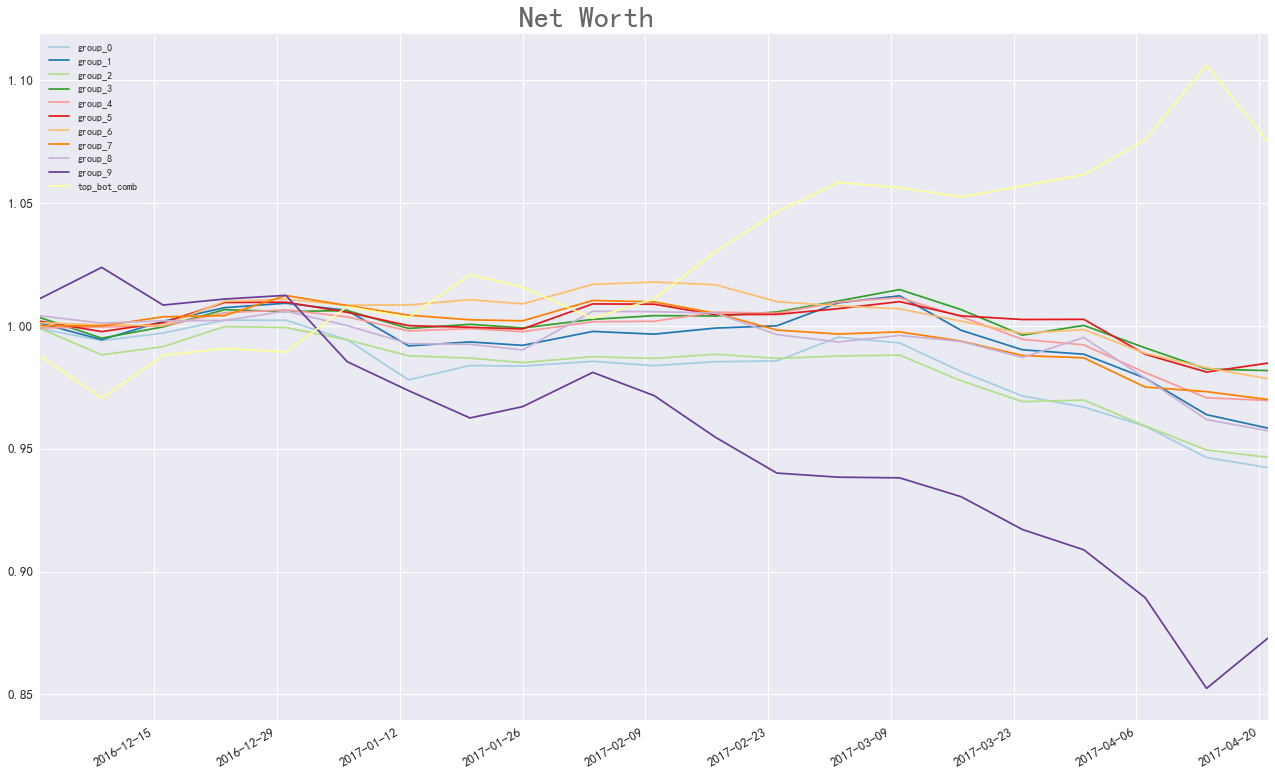

In [985]:
# Net worth plot 
netWorthDF = (ReturnDF.astype(float)+1).cumprod()
fig = plt.figure(figsize=(18,14))
# Add a subplot
ax = fig.add_subplot(111)
netWorthDF.plot(figsize=(22,14),ax=ax,color=sns.color_palette("Paired",11),title ='Net Worth',fontsize =13)
ax.set_title(ax.get_title(),alpha=0.7, fontsize=30, ha='right')

In [986]:
# Calc spearman correlation to investigate monotonicity
referSeries = pd.Series(index = netWorthDF.iloc[:,:-1].columns, data=range(len(netWorthDF.iloc[:,:-1].columns)))
monoDF = pd.DataFrame(index = netWorthDF.index, columns=['Spearman_Cor'], dtype = float)
for date in netWorthDF.index:
    monoDF.loc[date] = netWorthDF.iloc[:,:-1].loc[date].corr(referSeries,method='spearman')  

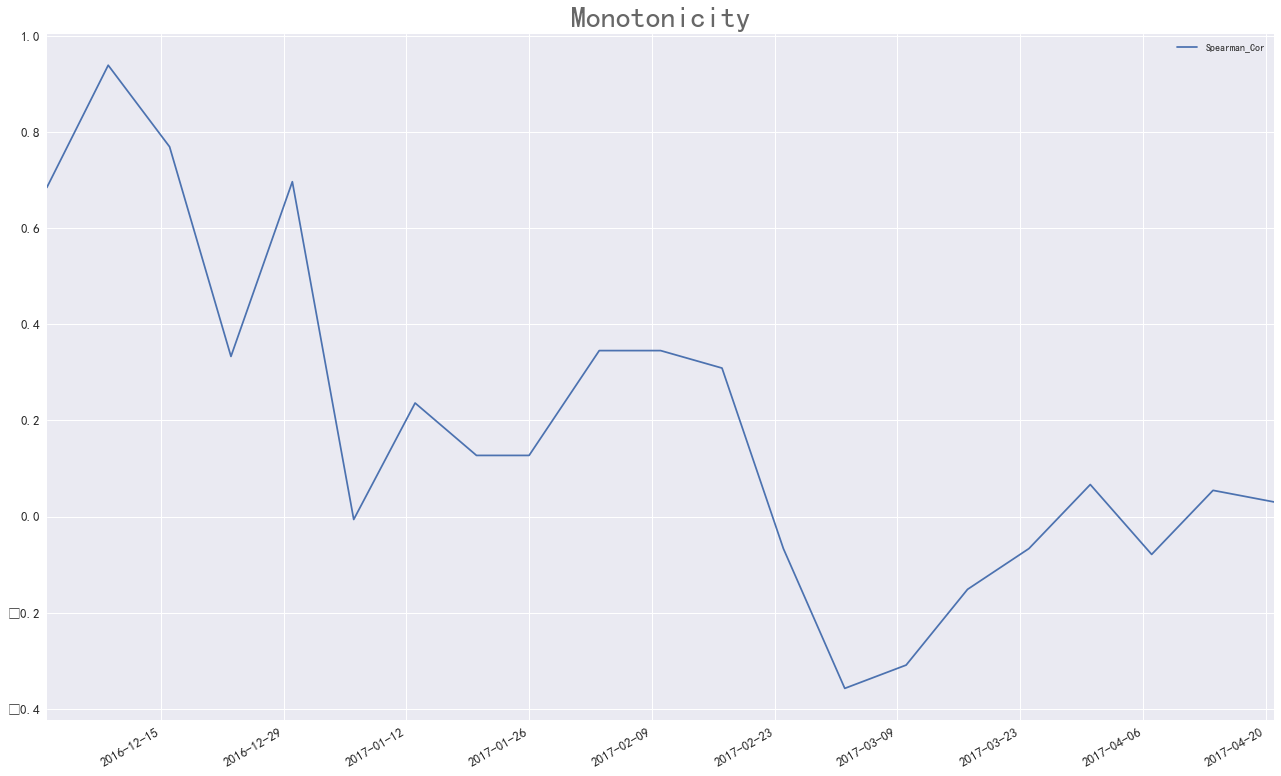

In [987]:
# Plot
fig = plt.figure(figsize=(18,14))
# Add a subplot
ax = fig.add_subplot(111)
monoDF.plot(figsize=(22,14),ax=ax,fontsize =13,title ='Monotonicity')
ax.set_title(ax.get_title(),alpha=0.7, fontsize=30)

In [988]:
# basic indicator
annualizedReturn = (1+ReturnDF.mean())**50 - 1
annualizedVol = ReturnDF.std()* np.sqrt(50)
sharpeRatio = annualizedReturn / annualizedVol 
print 'Annual Return:','\n',annualizedReturn,'\n\n','Annual Volatility:','\n',annualizedVol,'\n\n','Sharpe Ratio:''\n',sharpeRatio

Annual Return: 
group_0        -0.130899
group_1        -0.095085
group_2        -0.122135
group_3        -0.042025
group_4        -0.070139
group_5        -0.034947
group_6        -0.049951
group_7        -0.069309
group_8        -0.097439
group_9        -0.272379
top_bot_comb    0.193099
dtype: float64 

Annual Volatility: 
group_0         0.047380
group_1         0.050672
group_2         0.037359
group_3         0.038663
group_4         0.034330
group_5         0.037987
group_6         0.031910
group_7         0.032431
group_8         0.052536
group_9         0.107612
top_bot_comb    0.100158
dtype: float64 

Sharpe Ratio:
group_0        -2.762748
group_1        -1.876495
group_2        -3.269238
group_3        -1.086956
group_4        -2.043062
group_5        -0.919986
group_6        -1.565373
group_7        -2.137153
group_8        -1.854700
group_9        -2.531117
top_bot_comb    1.927944
dtype: float64


In [989]:
copyReturn = ReturnDF.copy()
copyReturn[copyReturn > copyReturn.mean()] =0
downsideRisk = ReturnDF.std(skipna = True) * np.sqrt(12)
downsideRisk

group_0         0.023211
group_1         0.024824
group_2         0.018302
group_3         0.018941
group_4         0.016818
group_5         0.018610
group_6         0.015633
group_7         0.015888
group_8         0.025737
group_9         0.052719
top_bot_comb    0.049067
dtype: float64

In [990]:
sortinoRatio = annualizedReturn / downsideRisk
sortinoRatio

group_0        -5.639437
group_1        -3.830379
group_2        -6.673304
group_3        -2.218740
group_4        -4.170382
group_5        -1.877914
group_6        -3.195303
group_7        -4.362445
group_8        -3.785890
group_9        -5.166621
top_bot_comb    3.935398
dtype: float64

In [991]:
# Max drawdown
maxdd = netWorthDF.copy()
maxdd.iloc[0] = 0
for date in netWorthDF.index[1:]:
    maxdd.loc[date] = 1-netWorthDF.loc[date]/netWorthDF.loc[:date].max()
maxddInfo = pd.concat([maxdd.max(),maxdd.idxmax()],axis=1)
maxddInfo.columns = ['Max_drawdown','Time']
maxddInfo

,Max_drawdown,Time
group_0,0.059865,2017-04-21
group_1,0.053215,2017-04-21
group_2,0.053266,2017-04-21
group_3,0.032507,2017-04-21
group_4,0.041350,2017-04-21
group_5,0.028383,2017-04-14
group_6,0.038708,2017-04-21
group_7,0.041806,2017-04-21
group_8,0.048455,2017-04-21
group_9,0.167365,2017-04-14


In [992]:
# calmar Ratio
calmarRatio = annualizedReturn/ maxddInfo['Max_drawdown']
calmarRatio

group_0        -2.186561
group_1        -1.786809
group_2        -2.292910
group_3        -1.292817
group_4        -1.696228
group_5        -1.231280
group_6        -1.290436
group_7        -1.657866
group_8        -2.010925
group_9        -1.627458
top_bot_comb    6.821256
dtype: float64